In [ ]:
import pandas as pd

In [ ]:
dat=pd.read_excel('/content/D202.xlsx',encoding='utf-8')
dat.shape

(70368, 8)

In [ ]:
dat['DATE TIME']=pd.date_range(start='2016-10-22 00:14:00', end='2018-10-25', freq='15min')

In [ ]:
import bokeh
from bokeh.io import output_notebook
output_notebook()
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar



In [ ]:
cal=calendar()
holidays=cal.holidays(start=dat['DATE TIME'].min(), end=dat['DATE TIME'].max())
dat['IS_HOLIDAY']=(dat['DATE TIME'].isin(holidays)).astype('int')


In [ ]:
dat['DAY TYPE']=dat['DATE TIME'].apply(lambda x: 0 if x.dayofweek<=5  else 1)
dat.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE TIME,IS_HOLIDAY,DAY TYPE
0,Electric usage,2016-10-22,00:00:00,00:14:00,0.01,kWh,0.0,NaN,2016-10-22 00:14:00,0,0
1,Electric usage,2016-10-22,00:15:00,00:29:00,0.01,kWh,0.0,NaN,2016-10-22 00:29:00,0,0
2,Electric usage,2016-10-22,00:30:00,00:44:00,0.01,kWh,0.0,NaN,2016-10-22 00:44:00,0,0
3,Electric usage,2016-10-22,00:45:00,00:59:00,0.01,kWh,0.0,NaN,2016-10-22 00:59:00,0,0
4,Electric usage,2016-10-22,01:00:00,01:14:00,0.01,kWh,0.0,NaN,2016-10-22 01:14:00,0,0


In [ ]:
for i in range(1,6,1):
  dat['T_'+str(i)]= dat.USAGE.shift(i)

In [ ]:
dat.fillna(0.00, inplace=True)

In [ ]:
data=dat[(dat['DATE TIME']>=pd.to_datetime('01/11/2016'))&(dat['DATE TIME']<=pd.to_datetime('30/09/2017'))]

In [ ]:
data.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,DATE TIME,IS_HOLIDAY,DAY TYPE,T_1,T_2,T_3,T_4,T_5
0,Electric usage,2016-10-22,00:00:00,00:14:00,0.01,kWh,0.0,0.0,2016-10-22 00:14:00,0,0,0.00,0.0,0.0,0.0,0.0
1,Electric usage,2016-10-22,00:15:00,00:29:00,0.01,kWh,0.0,0.0,2016-10-22 00:29:00,0,0,0.01,0.0,0.0,0.0,0.0


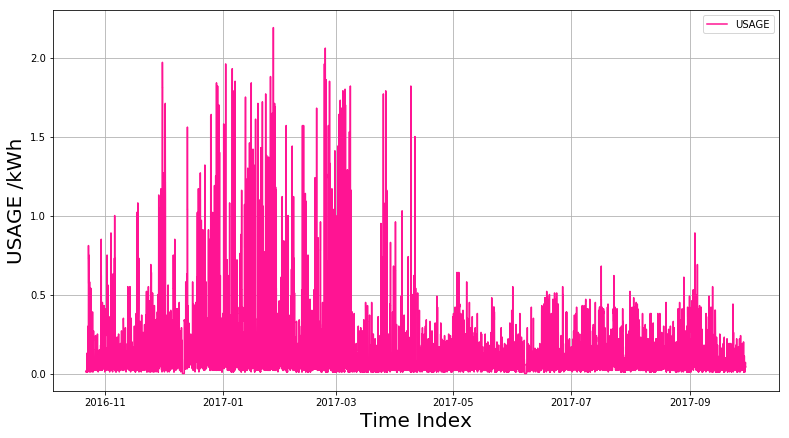

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from  matplotlib.pyplot import figure
figure(num=None,figsize=(13,7))
plt.plot(data['DATE TIME'],data['USAGE'], color='deeppink')
plt.legend()
plt.ylabel('USAGE /kWh', fontsize=20)
plt.xlabel('Time Index', fontsize=20)
plt.grid(True)
plt.show()

In [ ]:
trainig_data=data[data['DATE TIME']<pd.to_datetime('08/01/2017')]
validating_data=data[(data['DATE TIME']>pd.to_datetime('08/01/2017'))&(data['DATE TIME']<pd.to_datetime('09/01/2017'))]
test_data=data[data['DATE TIME']>pd.to_datetime('09/01/2017')]


In [ ]:
clean_train=trainig_data[['DAY TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_validate=validating_data[['DAY TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]
clean_test=test_data[['DAY TYPE', 'IS_HOLIDAY', 'T_1','T_2', 'T_3', 'T_4', 'T_5','USAGE']]



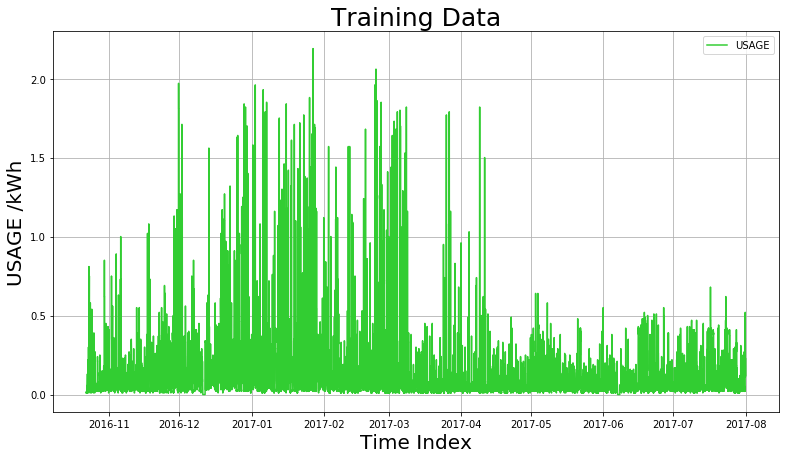

In [ ]:
figure(num=None,figsize=(13,7))
plt.plot(trainig_data['DATE TIME'],trainig_data['USAGE'], color='limegreen')
plt.legend()
plt.title('Training Data',fontsize=25)
plt.ylabel('USAGE /kWh', fontsize=20)
plt.xlabel('Time Index', fontsize=20)
plt.grid(True)
plt.show()

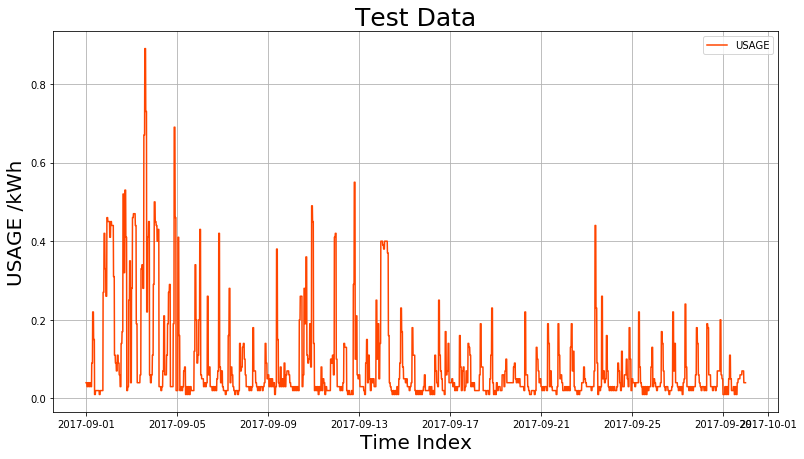

In [ ]:
figure(num=None,figsize=(13,7))
plt.plot(test_data['DATE TIME'],test_data['USAGE'], color='Orangered')
plt.legend()
plt.title('Test Data',fontsize=25)
plt.ylabel('USAGE /kWh', fontsize=20)
plt.xlabel('Time Index', fontsize=20)
plt.grid(True)
plt.show()

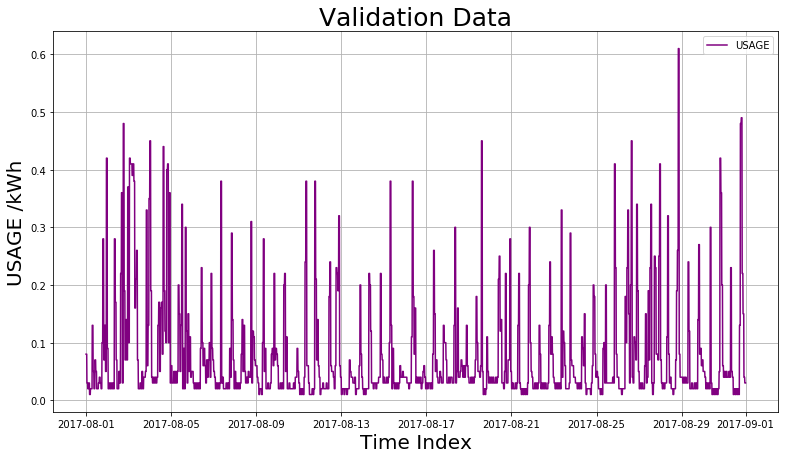

In [ ]:
figure(num=None,figsize=(13,7))
plt.plot(validating_data['DATE TIME'],validating_data['USAGE'], color='purple')
plt.legend()
plt.title('Validation Data',fontsize=25)
plt.ylabel('USAGE /kWh', fontsize=20)
plt.xlabel('Time Index', fontsize=20)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [ ]:
x_train=(clean_train.drop('USAGE', axis=1)).values
y_train=clean_train['USAGE'].values
x_val,y_val=(clean_validate.drop('USAGE', axis=1)).values,clean_validate['USAGE'].values
x_test,y_test=(clean_test.drop('USAGE', axis=1)).values,clean_test['USAGE'].values
#x_train.reshape(27168,1)
y_train=y_train.reshape(27168,1)
x_train=x_train.reshape(27168,7)
y_val=y_val.reshape(2976,1)
x_val=x_val.reshape(2976,7)
y_test=y_test.reshape(2784,1)
x_test=x_test.reshape(2784,7)



y_train.shape

(27168, 1)

In [ ]:
scaler = StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
y_train_scaled=scaler.fit_transform(y_train)

x_val_scaled=scaler.fit_transform(x_val)
y_val_scaled=scaler.fit_transform(y_val)


x_test_scaled=scaler.fit_transform(x_test)
y_test_scaled=scaler.fit_transform(y_test)



x_train_scaled.shape

(27168, 7)

In [ ]:
import numpy as np
x_train_scaled=np.expand_dims(x_train_scaled, axis=1)
x_val_scaled=np.expand_dims(x_val_scaled, axis=1)
x_test_scaled=np.expand_dims(x_test_scaled,axis=1)
x_train_scaled.shape

(27168, 1, 7)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,GRU
from keras.optimizers import adam,RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
import time
unit=time.time()


directory_2='/content/tensorboard/energy_consum{}'.format(unit)

tensorboard=TensorBoard(log_dir=directory_2)
model_check=ModelCheckpoint(filepath='/content/model_ch{}'.format(unit),monitor='loss',save_best_only=True,
                            save_weights_only=True, verbose=1)

earl_stop=EarlyStopping(monitor='val_loss',patience=5, verbose=1)



earl_stp=()

print('...Building up a model')
model=Sequential()
model.add(LSTM(512, input_shape=(1,7), dropout=0.2))
model.add(Dense(1))
optimizer=RMSprop(lr=0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)


...Building up a model


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 512)               1064960   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 1,065,473
Trainable params: 1,065,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history=model.fit(x_train_scaled, y_train_scaled, 
                      validation_data=(x_val_scaled,y_val_scaled), 
                      callbacks=[tensorboard,model_check,earl_stop],epochs=10, batch_size=96, verbose=0)

Train on 27168 samples, validate on 2976 samples
Epoch 1/10
 - 14s - loss: 0.3992 - val_loss: 0.3044

Epoch 00001: loss improved from inf to 0.39924, saving model to /content/model_ch1567004938.312841
Epoch 2/10
 - 12s - loss: 0.3415 - val_loss: 0.2967

Epoch 00002: loss improved from 0.39924 to 0.34151, saving model to /content/model_ch1567004938.312841
Epoch 3/10
 - 12s - loss: 0.3379 - val_loss: 0.2982

Epoch 00003: loss improved from 0.34151 to 0.33794, saving model to /content/model_ch1567004938.312841
Epoch 4/10
 - 12s - loss: 0.3215 - val_loss: 0.2727

Epoch 00004: loss improved from 0.33794 to 0.32147, saving model to /content/model_ch1567004938.312841
Epoch 5/10
 - 13s - loss: 0.3266 - val_loss: 0.2734

Epoch 00005: loss did not improve from 0.32147
Epoch 6/10
 - 13s - loss: 0.3133 - val_loss: 0.2829

Epoch 00006: loss improved from 0.32147 to 0.31329, saving model to /content/model_ch1567004938.312841
Epoch 7/10
 - 13s - loss: 0.3100 - val_loss: 0.2704

Epoch 00007: loss impr

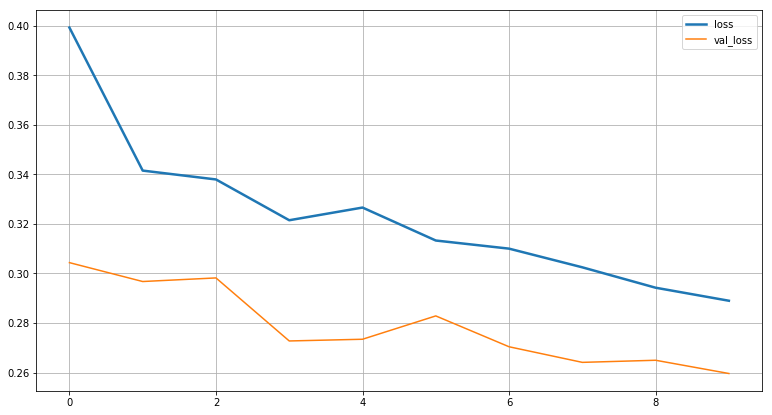

In [ ]:

figure(num=None, figsize=(13,7))
plt.plot(history.history['loss'], linewidth=2.5, label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.grid(True)


plt.show()

In [ ]:
y_pre=model.predict(x_test_scaled)

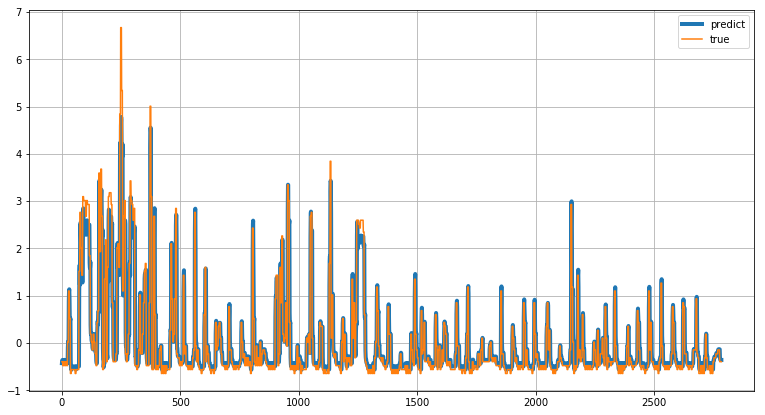

In [ ]:
figure(num=None, figsize=(13,7))
plt.plot(y_pre,label='predict',linewidth=4)
plt.plot(y_test_scaled,label='true')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pre.plot()

AttributeError: ignored